# Goal
The goal of this notebook is the development of the Data Loader class with (hopefully) best practices

In [1]:
import pandas as pd
from netCDF4 import Dataset as DS
import numpy as np
import torch
import glob
import logging
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import xarray as xr
import h5py


## Initialize class

In [2]:
file_path = '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/'

In [3]:
def get_data_loader(params, files_pattern, distributed, train, device, patch_size):

  dataset = GetDataset(params, files_pattern, train, device, patch_size)
  sampler = DistributedSampler(dataset, shuffle=train) if distributed else None
  
  dataloader = DataLoader(
                          dataset,
                          batch_size=int(params['batch_size']),
                          num_workers=params['num_data_workers'],
                          shuffle=False, #(sampler is None),
                          sampler=sampler if train else None,
                          drop_last=True,
                          pin_memory=torch.cuda.is_available()
                         )

  if train:
    return dataloader, dataset, sampler
  else:
    return dataloader, dataset

class GetDataset(Dataset):
    def __init__(self, params, file_path, train, device, patch_size):
        self.params = params
        self.file_path = file_path
        self.train = train
        print("params", params)
        self.dt = params['dt']
        self.n_history = params['n_history']
        self.in_channels = np.array(params['in_channels'])
        self.out_channels = np.array(params['out_channels'])
        self.n_in_channels  = 5#len(self.in_channels)
        self.n_out_channels = 5#len(self.out_channels)
        self.roll = params['roll']
        self._get_files_stats(file_path)
        self.add_noise = params['add_noise'] if train else False
        self.p_means = h5py.File(params['pressure_static_data_path'])
        self.s_means = h5py.File(params['surface_static_data_path'])
        self.patch_size = patch_size
        self.device = device
        try:
            self.normalize = params.normalize
        except:
            self.normalize = True #by default turn on normalization if not specified in config

    def _get_files_stats(self, file_path, dt=6):
        self.files_paths_pressure = glob.glob(file_path + "/????.h5") # indicates file paths for pressure levels
        self.files_paths_surface = glob.glob(file_path + "/single_????.h5") # indicates file paths for pressure levels

        
        self.files_paths_pressure.sort()
        self.files_paths_surface.sort()
        
        assert len(self.files_paths_pressure) == len(self.files_paths_surface), "Number of years not identical in pressure vs. surface level data."
    
        self.n_years = len(self.files_paths_pressure)
        with h5py.File(self.files_paths_pressure[0], 'r') as _f:
            logging.info("Getting file stats from {}".format(self.files_paths_pressure[0]))
            self.n_samples_per_year = _f['fields'].shape[0]
            #original image shape (before padding)
            self.img_shape_x = _f['fields'].shape[2]
            self.img_shape_y = _f['fields'].shape[3]
            self.n_in_channels = 13 #TODO
        self.n_samples_total = self.n_years * self.n_samples_per_year
        self.files_pressure = [None for _ in range(self.n_years)]
        self.files_surface = [None for _ in range(self.n_years)]
        
        logging.info("Number of samples per year: {}".format(self.n_samples_per_year))
        logging.info("Found data at path {}. Number of examples: {}. Image Shape: {} x {} x {}".format(file_path, self.n_samples_total, self.img_shape_x, self.img_shape_y, self.n_in_channels))
        logging.info("Delta t: {} hours".format(6*self.dt))
        
    def _open_pressure_file(self, year_idx):
        _file = h5py.File(self.files_paths_pressure[year_idx], 'r')
        self.files_pressure[year_idx] = _file
        
    def _open_surface_file(self, year_idx):
        _file = h5py.File(self.files_paths_surface[year_idx], 'r')
        self.files_surface[year_idx] = _file
      
    def __len__(self):
        return self.n_samples_total
    
    def __getitem__(self, global_idx, normalize=True):
        # TODO: not yet safety checked for edge cases or other errors
        # TODO: Not compatible (from the data aspect) with different dt times as in PGW
        year_idx  = int(global_idx/self.n_samples_per_year) #which year we are on
        local_idx = int(global_idx%self.n_samples_per_year) #which sample in that year we are on - determines indices for centering

        # open image file
        # TODO: where to close the respective files?
        if self.files_pressure[year_idx] is None:
            self._open_pressure_file(year_idx)
    
        if self.files_surface[year_idx] is None:
            self._open_surface_file(year_idx)
        
        step = self.dt
        target_step = local_idx + step
        if target_step == self.n_samples_per_year:
            target_step = local_idx

        if normalize:
            t1 = torch.as_tensor((self.files_pressure[year_idx]['fields'][local_idx] - self.p_means['mean']) / self.p_means['std_dev'])
            t2 = torch.as_tensor((self.files_surface[year_idx]['fields'][local_idx] - self.s_means['mean']) / self.s_means['std_dev'])
            t3 = torch.as_tensor((self.files_pressure[year_idx]['fields'][target_step] - self.p_means['mean']) / self.p_means['std_dev'])
            t4 = torch.as_tensor((self.files_surface[year_idx]['fields'][target_step] - self.s_means['mean']) / self.s_means['std_dev'])
        else:
            t1 = self.files_pressure[year_idx]['fields'][local_idx]
            t2 = self.files_surface[year_idx]['fields'][local_idx]
            t3 = self.files_pressure[year_idx]['fields'][target_step]
            t4 = self.files_surface[year_idx]['fields'][target_step]
        
        t1, t2, t3, t4 = self._pad_data(t1, t2, t3, t4)
        return t1, t2, t3, t4

        
    def _pad_data(self, t1, t2, t3, t4):
        # perform padding for patch embedding step
        input_shape = t1.shape  # shape is (5 variables x 13 pressure levels x 721 latitude x 1440 longitude)
        input_surface_shape = t2.shape
        
        
        x1_pad    = (self.patch_size[0] - (input_shape[1] % self.patch_size[0])) % self.patch_size[0] // 2
        x2_pad    = (self.patch_size[0] - (input_shape[1] % self.patch_size[0])) % self.patch_size[0] - x1_pad
        y1_pad    = (self.patch_size[1] - (input_shape[2] % self.patch_size[1])) % self.patch_size[1] // 2
        y2_pad    = (self.patch_size[1] - (input_shape[2] % self.patch_size[1])) % self.patch_size[1] - y1_pad
        z1_pad    = (self.patch_size[2] - (input_shape[3] % self.patch_size[2])) % self.patch_size[2] // 2
        z2_pad    = (self.patch_size[2] - (input_shape[3] % self.patch_size[2])) % self.patch_size[2] - z1_pad

        # pad pressure fields input and output
        t1 = torch.nn.functional.pad(t1, pad=(z1_pad, z2_pad, y1_pad, y2_pad, x1_pad, x2_pad), mode='constant', value=0)
        t3 = torch.nn.functional.pad(t3, pad=(z1_pad, z2_pad, y1_pad, y2_pad, x1_pad, x2_pad), mode='constant', value=0)
        
        # pad 
        t2  = torch.nn.functional.pad(t2, pad=(z1_pad, z2_pad, y1_pad, y2_pad), mode='constant', value=0)
        t4  = torch.nn.functional.pad(t4, pad=(z1_pad, z2_pad, y1_pad, y2_pad), mode='constant', value=0)

        return t1, t2, t3, t4
    

In [4]:
params = {}
params['dt'] = 1
params['n_history'] = 1
params['in_channels'] = 8
params['out_channels'] = 8
params['roll'] = False
params['add_noise'] = False

dataset = GetDataset(params=params, location='/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/', train=True)
dataset.__getitem__(0)

TypeError: __init__() got an unexpected keyword argument 'location'

In [129]:
def reshape_fields(img, inp_or_tar, crop_size_x, crop_size_y, params, y_roll, train, normalize=True, add_noise=False):
    #Takes in np array of size (n_history+1, c, h, w) and returns torch tensor of size ((n_channels*(n_history+1), crop_size_x, crop_size_y)
    if len(np.shape(img)) == 3:
      img = np.expand_dims(img, 0)

    n_history = np.shape(img)[0] - 1
    img_shape_x = np.shape(img)[-2]
    img_shape_y = np.shape(img)[-1]
    n_channels = np.shape(img)[1] #this will either be N_in_channels or N_out_channels
    channels = params.in_channels if inp_or_tar =='inp' else params.out_channels
    means = np.load(params.global_means_path)[:, channels]
    stds = np.load(params.global_stds_path)[:, channels]
    
    if normalize:
        if params.normalization == 'minmax':
          raise Exception("minmax not supported. Use zscore")
        elif params.normalization == 'zscore':
          img -= means
          img /= stds

    if params.roll:
        img = np.roll(img, y_roll, axis = -1)


    if inp_or_tar == 'inp':
        img = np.reshape(img, (n_channels*(n_history+1), img_shape_x, img_shape_y))
    elif inp_or_tar == 'tar':
        img = np.reshape(img, (n_channels, img_shape_x, img_shape_y))

    if add_noise:
        img = img + np.random.normal(0, scale=params.noise_std, size=img.shape)

    return torch.as_tensor(img)

In [184]:
d2 = h5py.File('/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/single_1980.h5')

In [186]:
d2['fields'].shape

(96, 4, 721, 1440)

In [142]:
path = '/hkfs/work/workspace/scratch/ke4365-pangu/pangu-weather/trained_models/pangum1.pt'

In [143]:
from networks import pangu
import sys
import torch
from importlib import reload  # Python 3.4+
reload(pangu)

sys.path.append('/hkfs/work/workspace/scratch/ke4365-pangu/pangu-weather/networks')
model = pangu.PanguModel()

/home/hk-project-epais/ke4365/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/hkfs/home/project/hk-project-epais/ke4365/.local/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


folder path!  constant_masks/


/software/all/jupyter/tensorflow/2023-09-12/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [144]:
try:
    # Load the model checkpoint
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint)
except RuntimeError as e:
    # Handle the case where the model was trained with DataParallel
    if 'module.' in str(e):
        new_checkpoint = {}
        for key, value in checkpoint.items():
            print("key, value", key)
            new_key = key.replace('module.', '') if 'module.' in key else key
            new_checkpoint[new_key] = value
        model.load_state_dict(new_checkpoint)
    else:
        raise  # Re-raise the error if it's not related to 'module.'


key, value module._input_layer.conv.weight
key, value module._input_layer.conv.bias
key, value module._input_layer.conv_surface.weight
key, value module._input_layer.conv_surface.bias
key, value module.layer1.blocks.0.norm1.weight
key, value module.layer1.blocks.0.norm1.bias
key, value module.layer1.blocks.0.norm2.weight
key, value module.layer1.blocks.0.norm2.bias
key, value module.layer1.blocks.0.linear.linear1.weight
key, value module.layer1.blocks.0.linear.linear1.bias
key, value module.layer1.blocks.0.linear.linear2.weight
key, value module.layer1.blocks.0.linear.linear2.bias
key, value module.layer1.blocks.0.attention.earth_specific_bias
key, value module.layer1.blocks.0.attention.linear1.weight
key, value module.layer1.blocks.0.attention.linear1.bias
key, value module.layer1.blocks.0.attention.linear2.weight
key, value module.layer1.blocks.0.attention.linear2.bias
key, value module.layer1.blocks.1.norm1.weight
key, value module.layer1.blocks.1.norm1.bias
key, value module.layer1

In [139]:
from utils import data_loader_multifiles

params = {}
params['train_data_path'] = '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/train_JQ//'
params['valid_data_path'] = '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/valid_JQ/'
params['pressure_static_data_path'] = '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/static/pressure_means_netcdf.npy'
params['surface_static_data_path'] = '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/static/surface_means_netcdf.npy'
params['dt'] = 1
params['n_history'] = 1
params['in_channels'] = 8
params['out_channels'] = 8
params['roll'] = False
params['add_noise'] = False
params['batch_size'] = 1
params['num_data_workers'] = 4
params['data_distributed'] = True
params['filetype'] = 'netcdf'

patch_size = (2, 4, 4)
train_data_loader, train_dataset, train_sampler = data_loader_multifiles.get_data_loader(params, params['train_data_path'], False, train=True, device='cpu', patch_size=patch_size)


params {'train_data_path': '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/train_JQ//', 'valid_data_path': '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/valid_JQ/', 'pressure_static_data_path': '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/static/pressure_means_netcdf.npy', 'surface_static_data_path': '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/static/surface_means_netcdf.npy', 'dt': 1, 'n_history': 1, 'in_channels': 8, 'out_channels': 8, 'roll': False, 'add_noise': False, 'batch_size': 1, 'num_data_workers': 4, 'data_distributed': True, 'filetype': 'netcdf'}
[  31   59   90  120  151  181  212  243  273  304  334  365  396  424
  455  485  516  546  577  608  638  669  699  730  761  789  820  850
  881  911  942  973 1003 1034 1064 1095 1126 1154 1185 1215 1246 1276
 1307 1338 1368 1399 1429 1460 1491 1519 1550 1580 1611 1641 1672 1703
 1733]


In [140]:
data = next(iter(train_data_loader))

In [145]:
result = model(data[0], data[1])

In [146]:
from torchsummary import summary

In [147]:
summary(model, [(5, 14, 724, 1440), (4, 724, 1440)])

Layer (type:depth-idx)                        Output Shape              Param #
├─PatchEmbedding: 1-1                         [-1, 521280, 192]         --
|    └─Conv3d: 2-1                            [-1, 192, 7, 181, 360]    30,912
|    └─Conv2d: 2-2                            [-1, 192, 181, 360]       21,696
├─EarthSpecificLayer: 1-2                     [-1, 521280, 192]         --
|    └─ModuleList: 2                          []                        --
|    |    └─EarthSpecificBlock: 3-1           [-1, 521280, 192]         2,908,992
|    |    └─EarthSpecificBlock: 3-2           [-1, 521280, 192]         2,908,992
├─DownSample: 1-3                             [-1, 131040, 384]         --
|    └─LayerNorm: 2-3                         [-1, 131040, 768]         1,536
|    └─Linear: 2-4                            [-1, 131040, 384]         294,912
├─EarthSpecificLayer: 1-4                     [-1, 131040, 384]         --
|    └─ModuleList: 2                          []                 

Layer (type:depth-idx)                        Output Shape              Param #
├─PatchEmbedding: 1-1                         [-1, 521280, 192]         --
|    └─Conv3d: 2-1                            [-1, 192, 7, 181, 360]    30,912
|    └─Conv2d: 2-2                            [-1, 192, 181, 360]       21,696
├─EarthSpecificLayer: 1-2                     [-1, 521280, 192]         --
|    └─ModuleList: 2                          []                        --
|    |    └─EarthSpecificBlock: 3-1           [-1, 521280, 192]         2,908,992
|    |    └─EarthSpecificBlock: 3-2           [-1, 521280, 192]         2,908,992
├─DownSample: 1-3                             [-1, 131040, 384]         --
|    └─LayerNorm: 2-3                         [-1, 131040, 768]         1,536
|    └─Linear: 2-4                            [-1, 131040, 384]         294,912
├─EarthSpecificLayer: 1-4                     [-1, 131040, 384]         --
|    └─ModuleList: 2                          []                 

In [153]:
# Variables are 
result[0].shape

torch.Size([1, 5, 14, 724, 1440])

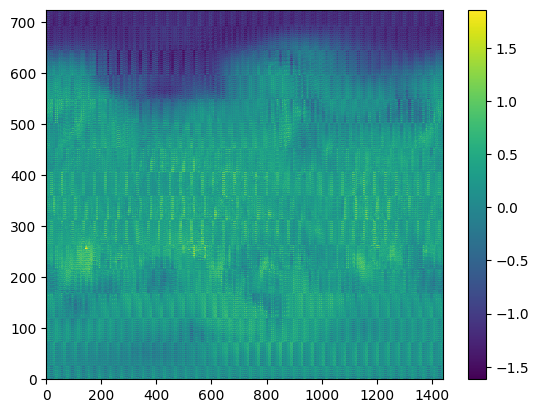

In [162]:
plt.pcolor(np.flipud(result[0][0][0][0].detach()))
plt.colorbar()

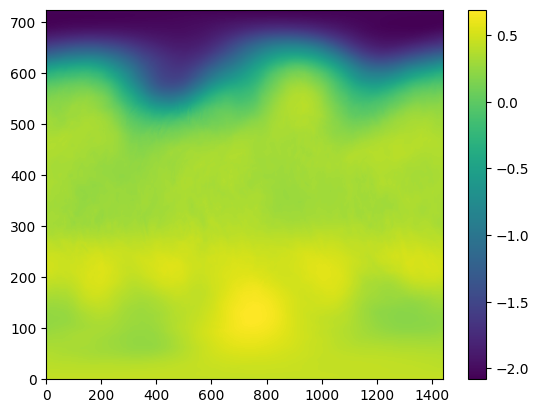

In [165]:
plt.pcolor(np.flipud(data[2][0][0][0]))
plt.colorbar()

# Loading data directly from netcdf

In [5]:
from netCDF4 import Dataset as DS
import netCDF4 as nc

In [6]:
era_path = '/lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2023-07_pl.nc'

In [7]:
ds = nc.Dataset(era_path)

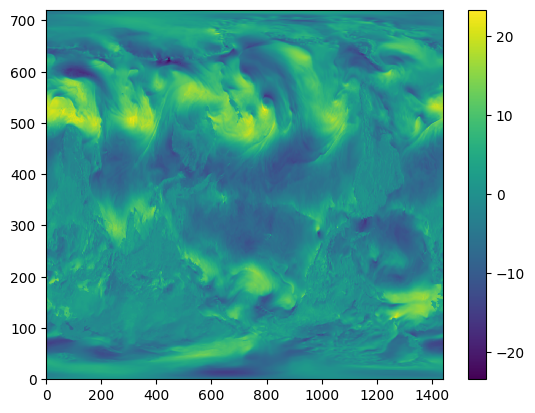

In [9]:
plt.pcolor(ds['U'][0][12])
plt.colorbar()

In [102]:
isotime = ds.isel(time=28)
nparr =np.stack([isotime['Z'].values, isotime['Q'].values,isotime['T'].values, isotime['U'].values, isotime['V'].values], axis=0)

In [120]:
means = h5py.File('/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/static/pressure_means.h5')

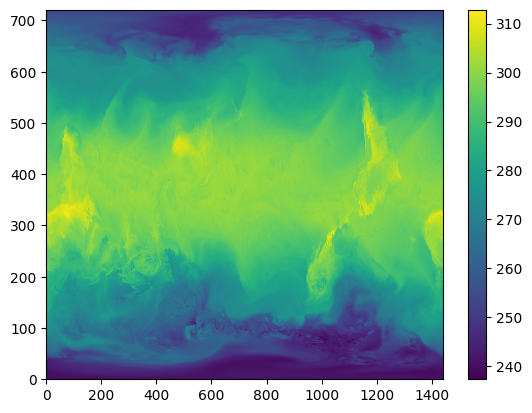

In [109]:
# Order of fields: Z, Q, T, U, V
# PL goes from HIGH to LOW
plt.pcolor(nparr[2, 12, :, :])
plt.colorbar()

In [6]:
h5data = h5py.File('/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/train/1980.h5')

In [7]:
# Fields: Z, Q, T, U, V
# For PL 50 (smallest)
# Z range: 0.0025 -- 0.02
# Q range: -3000 -- 3000
h5data['fields'][0].shape

(5, 13, 721, 1440)

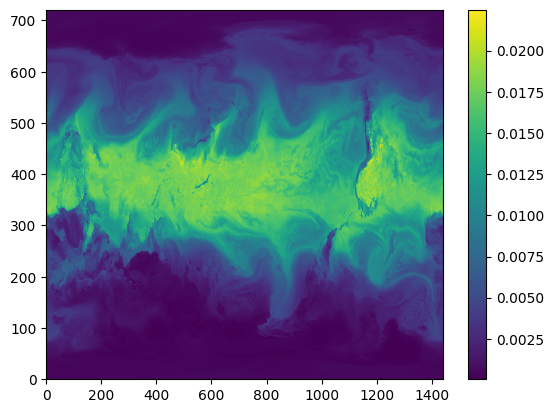

In [11]:
plt.pcolor(h5data['fields'][0, 1, 0])
plt.colorbar()

# Compute means and std

In [75]:
import random
# List of files
file_list_plevel  = glob.glob('/lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/*_pl.nc') 
file_list_surface = glob.glob('/lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/*_sfc.nc') 

# Initialize variables for calculation
mean_sum_plevel = None
sq_sum_plevel = None
count = 0

# Process each file in plevels
for file_name in file_list_plevel:
    
    print("processing file", file_name)
    data = xr.open_dataset(file_name)

    num_points = len(data.time)
    rng = random.randint(0, num_points-1)

    # isolate time point and convert to numpy array
    data = data.isel(time=rng)
    data = np.stack([data['Z'].values, data['Q'].values, data['T'].values, data['U'].values, data['V'].values], axis=0)
    data = data.reshape(1, 5, 13, 721, 1440)

    if mean_sum_plevel is None:
        # Initialize arrays for the first file
        mean_sum_plevel = np.zeros((1, data.shape[1], data.shape[2], 1, 1), dtype=np.float32)
        sq_sum_plevel   = np.zeros((1, data.shape[1], data.shape[2], 1, 1), dtype=np.float32)

    # Summation for mean and standard deviation
    mean_sum_plevel += np.mean(data, keepdims=True, axis = (0, 3, 4))[0]
    sq_sum_plevel += np.var(data, keepdims=True, axis = (0, 3, 4))[0]


processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2020-09_pl.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2021-03_pl.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2021-04_pl.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2019-09_pl.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2021-11_pl.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2022-06_pl.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2018-11_pl.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2019-06_pl.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2018-08_pl.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2023-01_pl.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2018-05_pl.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quin

In [77]:
# Shape of the pressure mean and std should be (5, 13, 1, 1)
# Shape of the surface mean and std should be (4, 1, 1)
mean_plevel = mean_sum_plevel / len(file_list_plevel)
std_plevel  = np.sqrt(sq_sum_plevel/len(file_list_plevel))

mean_plevel = mean_plevel[0, :]
std_plevel  = std_plevel[0, :]
# Save the results
output_file = '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/static/pressure_means_netcdf.npy'
np.save(output_file, np.stack([mean_plevel, std_plevel]))
print(f"Output of pressure levels saved in {output_file}")


Output of pressure levels saved in /hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/static/pressure_means_netcdf.npy


In [80]:
static_plevel = np.load('/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/static/pressure_means_netcdf.npy')

In [84]:
mean_plevel = static_plevel[0].reshape(1, 5, 13, 1, 1)
std_plevel  = static_plevel[1].reshape(1, 5, 13, 1, 1)
print(mean_plevel.shape)

(1, 5, 13, 1, 1)


In [79]:
plt.pcolor(((data[0] - mean_plevel)/std_plevel)[3][12])
plt.colorbar()

IndexError: index 3 is out of bounds for axis 0 with size 2

In [48]:
# Initialize variables for calculation
mean_sum_surface = None
sq_sum_surface = None
count = 0

# Process each file in plevels
for file_name in file_list_surface:
    
    print("processing file", file_name)
    data = xr.open_dataset(file_name)

    num_points = len(data.time)
    rng = random.randint(0, num_points-1)

    # isolate time point and convert to numpy array
    data = data.isel(time=rng)
    data = np.stack([data['MSL'].values, data['U10M'].values, data['V10M'].values, data['T2M'].values], axis=0)
    data = data.reshape(1, 4, 721, 1440)

    if mean_sum_surface is None:
        # Initialize arrays for the first file
        mean_sum_surface = np.zeros((1, data.shape[1], 1, 1), dtype=np.float32)
        sq_sum_surface   = np.zeros((1, data.shape[1], 1, 1), dtype=np.float32)

    # Summation for mean and standard deviation
    mean_sum_surface += np.mean(data, keepdims=True, axis = (0, 2, 3))[0]
    sq_sum_surface += np.var(data, keepdims=True, axis = (0, 2, 3))[0]


processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2019-02_sfc.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2021-08_sfc.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2023-03_sfc.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2022-03_sfc.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2021-09_sfc.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2022-10_sfc.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2018-02_sfc.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2019-03_sfc.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2021-10_sfc.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2019-01_sfc.nc
processing file /lsdf/kit/imk-tro/projects/Gruppe_Quinting/ec.era5/era5_2019-09_sfc.nc
processing file /lsdf/kit/imk-tro/projects/

In [66]:
# Shape of the pressure mean and std should be (5, 13, 1, 1)
# Shape of the surface mean and std should be (4, 1, 1)
mean_surface = mean_sum_surface / len(file_list_surface)
std_surface  = np.sqrt(sq_sum_surface/len(file_list_surface))

mean_surface = mean_surface[0, :]
std_surface  = std_surface[0, :]

# Save the results
np.save('/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/static/surface_means_netcdf.npy', np.stack([mean_surface, std_surface]))
print(f"Output of pressure levels saved in {output_file}")

Output of pressure levels saved in /hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/static/pressure_means_netcdf.npy


In [55]:
mean_surface = np.load('/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/static/surface_means_netcdf.npy')
std_surface  = np.load('/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/static/surface_std_netcdf.npy')

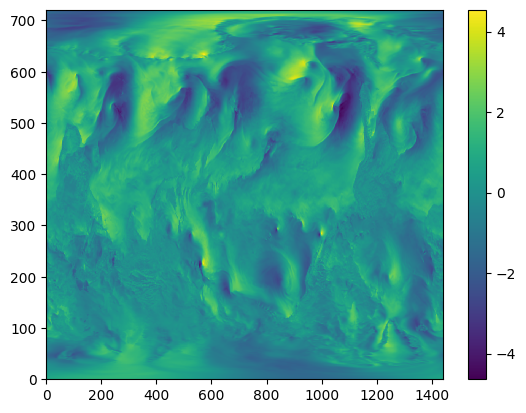

In [60]:
plt.pcolor(((data[0] - mean_surface)/std_surface)[2])
plt.colorbar()

In [119]:
class GetDataset(Dataset):
    def __init__(self, params, file_path, train, device, patch_size):
        self.params = params
        self.file_path = file_path
        self.train = train
        print("params", params)
        self.dt = params['dt']
        self.n_history = params['n_history']
        self.in_channels = np.array(params['in_channels'])
        self.out_channels = np.array(params['out_channels'])
        self.n_in_channels  = 5#len(self.in_channels)
        self.n_out_channels = 5#len(self.out_channels)
        self.roll = params['roll']
        self.filetype = params['filetype']
        self._get_files_stats(file_path)
        self.add_noise = params['add_noise'] if train else False
        if params['filetype'] == 'hdf5':
            self.p_means = h5py.File(params['pressure_static_data_path'])
            self.s_means = h5py.File(params['surface_static_data_path'])
        else:
            self.p_mean = np.load(params['pressure_static_data_path'])[0].reshape(1, 5, 13, 1, 1)
            self.p_std  = np.load(params['pressure_static_data_path'])[1].reshape(1, 5, 13, 1, 1)
            self.s_mean = np.load(params['surface_static_data_path'])[0].reshape(1, 4, 1, 1)
            self.s_std  = np.load(params['surface_static_data_path'])[1].reshape(1, 4, 1, 1)
        self.patch_size = patch_size
        self.device = device
        try:
            self.normalize = params.normalize
        except:
            self.normalize = True #by default turn on normalization if not specified in config

    def _get_files_stats(self, file_path, dt=6):
        if self.filetype == 'hdf5':
            self.files_paths_pressure = glob.glob(file_path + "/????.h5") # indicates file paths for pressure levels
            self.files_paths_surface = glob.glob(file_path + "/single_????.h5") # indicates file paths for pressure levels
        elif self.filetype == 'netcdf':
            self.files_paths_pressure = glob.glob(file_path + '/*_pl.nc')
            self.files_paths_surface = glob.glob(file_path + '/*_sfc.nc')
        else:
            return "Input data must be in either the hdf5 or netcdf format"
        
        self.files_paths_pressure.sort()
        self.files_paths_surface.sort()
        
        assert len(self.files_paths_pressure) == len(self.files_paths_surface), "Number of years not identical in pressure vs. surface level data."
    
        self.n_years = len(self.files_paths_pressure)

        if self.filetype == 'hdf5':
            with h5py.File(self.files_paths_pressure[0], 'r') as _f:
                logging.info("Getting file stats from {}".format(self.files_paths_pressure[0]))
                self.n_samples_per_year = _f['fields'].shape[0]
                #original image shape (before padding)
                self.img_shape_x = _f['fields'].shape[2]
                self.img_shape_y = _f['fields'].shape[3]
                self.n_in_channels = 13 #TODO
                self.n_samples_total = self.n_years * self.n_samples_per_year

        else:
            logging.info("Getting file stats from {}".format(self.files_paths_pressure[0]))
            ds = xr.open_dataset(self.files_paths_surface[0])
            #original image shape (before padding)
            self.img_shape_x = len(ds.lon) # 1440
            self.img_shape_y = len(ds.lat) # 721
            self.n_in_channels = len(ds.data_vars)
            n_points = 0
            self.cumulative_points_per_file = []
            self.points_per_file = []
            # Need to iterate through files to find the length because of leap years, incorrectly organized data, etc.
            for path in self.files_paths_surface:
                ds = xr.open_dataset(path)
                n_points = int(len(ds.time))
                self.points_per_file.append(n_points)
            self.cumulative_points_per_file = np.cumsum(np.array(self.points_per_file))
            print(self.cumulative_points_per_file)
            
            self.n_samples_total = n_points
            
        self.files_pressure = [None for _ in range(self.n_years)]
        self.files_surface  = [None for _ in range(self.n_years)]
        
        # logging.info("Number of samples per year: {}".format(self.n_samples_per_year))
        logging.info("Found data at path {}. Number of examples: {}. Image Shape: {} x {} x {}".format(file_path, self.n_samples_total, self.img_shape_x, self.img_shape_y, self.n_in_channels))
        logging.info("Delta t: {} hours".format(6*self.dt))
        
    def _open_pressure_file(self, file_idx):
        if self.filetype == 'hdf5':
            _file = h5py.File(self.files_paths_pressure[file_idx], 'r')
            self.files_pressure[file_idx] = _file
        else:
            _file = xr.open_dataset(self.files_paths_pressure[file_idx])
            self.files_pressure[file_idx] = _file
            
                    
    def _open_surface_file(self, file_idx):
        if self.filetype == 'hdf5':
            _file = h5py.File(self.files_paths_surface[file_idx], 'r')
            self.files_surface[file_idx] = _file
        else:
            _file = xr.open_dataset(self.files_paths_surface[file_idx])
            self.files_surface[file_idx] = _file

      
    def __len__(self):
        return self.n_samples_total
    
    def __getitem__(self, global_idx, normalize=True):
        # TODO: not yet safety checked for edge cases or other errors
        # TODO: Not compatible (from the data aspect) with different dt times as in PGW
        if self.filetype == 'hdf5':
            year_idx  = int(global_idx/self.n_samples_per_year) #which year we are on
            local_idx = int(global_idx%self.n_samples_per_year) #which sample in that year we are on - determines indices for centering

            # open image file
            # TODO: where to close the respective files?
            if self.files_pressure[year_idx] is None:
                self._open_pressure_file(year_idx)
        
            if self.files_surface[year_idx] is None:
                self._open_surface_file(year_idx)
            
            step = self.dt
            target_step = local_idx + step
            if target_step == self.n_samples_per_year:
                target_step = local_idx

            if normalize:
                t1 = torch.as_tensor((self.files_pressure[year_idx]['fields'][local_idx] - self.p_means['mean']) / self.p_means['std_dev'])
                t2 = torch.as_tensor((self.files_surface[year_idx]['fields'][local_idx] - self.s_means['mean']) / self.s_means['std_dev'])
                t3 = torch.as_tensor((self.files_pressure[year_idx]['fields'][target_step] - self.p_means['mean']) / self.p_means['std_dev'])
                t4 = torch.as_tensor((self.files_surface[year_idx]['fields'][target_step] - self.s_means['mean']) / self.s_means['std_dev'])
            else:
                t1 = torch.as_tensor(self.files_pressure[year_idx]['fields'][local_idx])
                t2 = torch.as_tensor(self.files_surface[year_idx]['fields'][local_idx])
                t3 = torch.as_tensor(self.files_pressure[year_idx]['fields'][target_step])
                t4 = torch.as_tensor(self.files_surface[year_idx]['fields'][target_step])
            
            t1, t2, t3, t4 = self._pad_data(t1, t2, t3, t4)
            return t1, t2, t3, t4
        
        else: # dealing directly with netcdf files
            step = self.dt
            target_step = global_idx + step
            
            # Get file and local_idx for the input steps
            input_file_idx  = np.argmax(self.cumulative_points_per_file > global_idx) #which year we are on
            if input_file_idx > 0:
                input_local_idx = global_idx - self.cumulative_points_per_file[input_file_idx - 1] #which sample in that year we are on - determines indices for centering
            else:
                input_local_idx = global_idx
            
            # Get file and local_idx for the output step
            output_file_idx  = np.argmax(self.cumulative_points_per_file > target_step) #which year we are on
            if output_file_idx > 0:
                output_local_idx = target_step - self.cumulative_points_per_file[output_file_idx - 1] #which sample in that year we are on - determines indices for centering
            else:
                output_local_idx = target_step
            
            # open files
            if self.files_pressure[input_file_idx] is None:
                self._open_pressure_file(input_file_idx)
        
            if self.files_surface[input_file_idx] is None:
                self._open_surface_file(input_file_idx)
            
            if self.files_pressure[output_file_idx] is None:
                self._open_pressure_file(output_file_idx)

            if self.files_surface[output_file_idx] is None:
                self._open_surface_file(output_file_idx)
            
            if target_step >= self.n_samples_total: # If we are at the very last step
                target_step = local_idx

            # Isolate data from time point and convert to numpy array
            input_time_pressure = self.files_pressure[input_file_idx].isel(time=input_local_idx)
            input_time_surface  = self.files_surface[input_file_idx].isel(time=input_local_idx)

            input_time_pressure = np.stack([input_time_pressure['Z'].values, input_time_pressure['Q'].values, input_time_pressure['T'].values, input_time_pressure['U'].values, input_time_pressure['V'].values], axis=0)
            input_time_surface  = np.stack([input_time_surface['MSL'].values, input_time_surface['U10M'].values, input_time_surface['V10M'].values, input_time_surface['T2M'].values], axis=0)

            output_time_pressure = self.files_pressure[output_file_idx].isel(time=output_local_idx)
            output_time_surface  = self.files_surface[output_file_idx].isel(time=output_local_idx)

            output_time_pressure = np.stack([output_time_pressure['Z'].values,  output_time_pressure['Q'].values,   output_time_pressure['T'].values,   output_time_pressure['U'].values, output_time_pressure['V'].values], axis=0)
            output_time_surface  = np.stack([output_time_surface['MSL'].values, output_time_surface['U10M'].values, output_time_surface['V10M'].values, output_time_surface['T2M'].values], axis=0)
            
            if normalize:
                # p_ and s_means is a stack of the mean and standard deviation values
                t1 = torch.as_tensor((input_time_pressure - self.p_mean) / self.p_std)
                t2 = torch.as_tensor((input_time_surface - self.s_mean)  / self.s_std)
                t3 = torch.as_tensor((output_time_pressure - self.p_mean) / self.p_std)
                t4 = torch.as_tensor((output_time_surface - self.s_mean)  / self.s_std)
            else:
                t1 = torch.as_tensor(input_time_pressure)
                t2 = torch.as_tensor(input_time_surface)
                t3 = torch.as_tensor(output_time_pressure)
                t4 = torch.as_tensor(output_time_surface)
            
            t1, t2, t3, t4 = self._pad_data(t1, t2, t3, t4)
            return t1, t2, t3, t4
        
    def _pad_data(self, t1, t2, t3, t4):
        # perform padding for patch embedding step
        input_shape = t1.shape  # shape is (5 variables x 13 pressure levels x 721 latitude x 1440 longitude)
        input_surface_shape = t2.shape
        
        
        x1_pad    = (self.patch_size[0] - (input_shape[1] % self.patch_size[0])) % self.patch_size[0] // 2
        x2_pad    = (self.patch_size[0] - (input_shape[1] % self.patch_size[0])) % self.patch_size[0] - x1_pad
        y1_pad    = (self.patch_size[1] - (input_shape[2] % self.patch_size[1])) % self.patch_size[1] // 2
        y2_pad    = (self.patch_size[1] - (input_shape[2] % self.patch_size[1])) % self.patch_size[1] - y1_pad
        z1_pad    = (self.patch_size[2] - (input_shape[3] % self.patch_size[2])) % self.patch_size[2] // 2
        z2_pad    = (self.patch_size[2] - (input_shape[3] % self.patch_size[2])) % self.patch_size[2] - z1_pad

        # pad pressure fields input and output
        t1 = torch.nn.functional.pad(t1, pad=(z1_pad, z2_pad, y1_pad, y2_pad, x1_pad, x2_pad), mode='constant', value=0)
        t3 = torch.nn.functional.pad(t3, pad=(z1_pad, z2_pad, y1_pad, y2_pad, x1_pad, x2_pad), mode='constant', value=0)
        
        # pad 
        t2  = torch.nn.functional.pad(t2, pad=(z1_pad, z2_pad, y1_pad, y2_pad), mode='constant', value=0)
        t4  = torch.nn.functional.pad(t4, pad=(z1_pad, z2_pad, y1_pad, y2_pad), mode='constant', value=0)

        return t1, t2, t3, t4
    


In [135]:

params = {}
params['train_data_path'] = '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/train_JQ/'
params['valid_data_path'] = '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/valid_JQ/'
params['pressure_static_data_path'] = '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/static/pressure_means_netcdf.npy'
params['surface_static_data_path'] = '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/static/surface_means_netcdf.npy'
params['dt'] = 1
params['n_history'] = 1
params['in_channels'] = 8
params['out_channels'] = 8
params['roll'] = False
params['add_noise'] = False
params['batch_size'] = 2
params['num_data_workers'] = 4
params['data_distributed'] = True
params['filetype'] = 'netcdf' # either hdf5 or netcdf

In [136]:
dataset = GetDataset(params, params['train_data_path'], train=True, device='cpu', patch_size=(2,4,4))

params {'train_data_path': '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/train_JQ/', 'valid_data_path': '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/valid_JQ/', 'pressure_static_data_path': '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/static/pressure_means_netcdf.npy', 'surface_static_data_path': '/hkfs/work/workspace/scratch/ke4365-pangu/PANGU_ERA5_data_v0/static/surface_means_netcdf.npy', 'dt': 1, 'n_history': 1, 'in_channels': 8, 'out_channels': 8, 'roll': False, 'add_noise': False, 'batch_size': 2, 'num_data_workers': 4, 'data_distributed': True, 'filetype': 'netcdf'}
[   31    90   180   300   451   632   844  1087  1360  1664  1998  2363
  2759  3183  3638  4123  4639  5185  5762  6370  7008  7677  8376  9106
  9867 10656 11476 12326 13207 14118 15060 16033 17036 18070 19134 20229
 21355 22509 23694 24909 26155 27431 28738 30076 31444 32843 34272 35732
 37223 38742 40292 41872 43483 45124 46796 48499 50232]


In [137]:
dataloader = DataLoader(dataset)

In [138]:
data[0].shape

torch.Size([1, 5, 14, 724, 1440])